# A Jupyter Notebook for Building and Evaluating Machine Learning Models for EV Charging Patterns
This notebook demonstrates the process of loading, preprocessing, and analyzing EV charging data, followed by building and evaluating machine learning models.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# CatBoost
from catboost import CatBoostClassifier, Pool

# SHAP for feature importance
import shap

# Hyperparameter optimization
import optuna

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and Explore Dataset
df = pd.read_csv('ev_charging_patterns.csv')

# Display the first few rows
df.head()

# Check data types and missing values
df.info()
df.isnull().sum()

# Statistical summary
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

,Battery Capacity (kWh),Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years)
count,1320.000000,1254.000000,1320.000000,1254.000000,1320.000000,1320.000000,1320.000000,1254.000000,1320.000000,1320.000000
mean,74.534692,42.642894,2.269377,25.963003,22.551352,49.130012,75.141590,153.596788,15.263591,3.612843
std,20.626914,22.411705,1.061037,14.011326,10.751494,24.074134,17.080580,86.004987,14.831216,2.309824
min,1.532807,0.045772,0.095314,1.472549,0.234317,2.325959,7.604224,0.862361,-10.724770,0.000000
25%,62.000000,23.881193,1.397623,13.856583,13.368141,27.786903,62.053266,79.445335,2.800664,2.000000
50%,75.000000,42.691405,2.258136,25.603799,22.076360,48.241771,75.682496,152.259867,14.630846,4.000000
75%,85.000000,61.206218,3.112806,37.502998,31.646044,69.277921,88.201370,226.073284,27.981810,6.000000
max,193.003074,152.238758,7.635145,97.342255,69.407743,152.489761,177.708666,398.364775,73.169588,11.688592


In [3]:
# Feature Engineering
# Convert 'Charging Start Time' to datetime
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])

# Extract temporal features
df['hour'] = df['Charging Start Time'].dt.hour
df['day_of_week'] = df['Charging Start Time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Calculate charging duration in hours
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])
df['Charging Duration'] = (df['Charging End Time'] - df['Charging Start Time']).dt.total_seconds() / 3600

# Drop original datetime columns
df.drop(['Charging Start Time', 'Charging End Time'], axis=1, inplace=True)

In [4]:
# Handle Missing Values
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Impute missing values using KNNImputer
imputer = KNNImputer()
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

In [5]:
# Encode Categorical Variables
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('User Type')  # Exclude target variable

# Apply Target Encoding to categorical variables
encoder = TargetEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols], df['User Type'])

In [6]:
# Scale Numerical Features
# Define features and target
X = df.drop('User Type', axis=1)
y = df['User Type']

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [7]:
# Split Dataset
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
# Apply SMOTE for Class Balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [9]:
# Train Logistic Regression Model
# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_resampled, y_resampled, cv=cv, scoring='f1_macro')
print(f"Logistic Regression CV F1-score: {cv_scores.mean():.4f}")

# Train the model
log_reg.fit(X_resampled, y_resampled)

# Predictions
y_pred_lr = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression CV F1-score: 0.9833
Logistic Regression Classification Report:
                        precision    recall  f1-score   support

         Casual Driver       1.00      0.99      0.99        82
              Commuter       0.99      0.98      0.98        95
Long-Distance Traveler       0.98      1.00      0.99        87

              accuracy                           0.99       264
             macro avg       0.99      0.99      0.99       264
          weighted avg       0.99      0.99      0.99       264



In [10]:
# Train CatBoost Model
# Initialize CatBoost model
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

# Cross-validation
cv_scores_cb = cross_val_score(catboost_model, X_resampled, y_resampled, cv=cv, scoring='f1_macro')
print(f"CatBoost CV F1-score: {cv_scores_cb.mean():.4f}")

# Train the model
catboost_model.fit(X_resampled, y_resampled)

# Predictions
y_pred_cb = catboost_model.predict(X_test)

# Evaluation
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cb))

CatBoost CV F1-score: 1.0000
CatBoost Classification Report:
                        precision    recall  f1-score   support

         Casual Driver       1.00      1.00      1.00        82
              Commuter       1.00      1.00      1.00        95
Long-Distance Traveler       1.00      1.00      1.00        87

              accuracy                           1.00       264
             macro avg       1.00      1.00      1.00       264
          weighted avg       1.00      1.00      1.00       264



In [11]:
# Hyperparameter Tuning with GridSearchCV
# Define pipeline and parameter grid
logistic_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_lr = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['liblinear']
}

grid_lr = GridSearchCV(
    logistic_pipeline,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_lr.fit(X_resampled, y_resampled)

print("🔎 Best parameters for Logistic Regression:", grid_lr.best_params_)
print("✅ Best F1 score from GridSearchCV (Logistic):", grid_lr.best_score_)

🔎 Best parameters for Logistic Regression: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
✅ Best F1 score from GridSearchCV (Logistic): 1.0


In [ ]:
# Hyperparameter Tuning with Optuna
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'iterations': trial.suggest_int('iterations', 100, 500),
        'random_state': 42,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1_macro').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, timeout=120)

print("🔎 Best parameters for CatBoost:", study.best_params)
print("✅ Best F1 score from Optuna (CatBoost):", study.best_value)

# Train the best CatBoost model
best_catboost = CatBoostClassifier(**study.best_params, random_state=42, verbose=0)
best_catboost.fit(X_resampled, y_resampled)

[I 2025-04-12 01:26:40,052] A new study created in memory with name: no-name-6c4792aa-6db6-4d1f-a9da-a57c41b6f218
[I 2025-04-12 01:26:48,039] Trial 0 finished with value: 1.0 and parameters: {'depth': 5, 'learning_rate': 0.018442029840861855, 'l2_leaf_reg': 0.004992540006948434, 'iterations': 174}. Best is trial 0 with value: 1.0.
[I 2025-04-12 01:27:49,697] Trial 1 finished with value: 1.0 and parameters: {'depth': 7, 'learning_rate': 0.23766293098939856, 'l2_leaf_reg': 2.2143878385086353, 'iterations': 419}. Best is trial 0 with value: 1.0.
[I 2025-04-12 01:30:02,723] Trial 2 finished with value: 1.0 and parameters: {'depth': 9, 'learning_rate': 0.0833994193032959, 'l2_leaf_reg': 0.0010746256168111077, 'iterations': 248}. Best is trial 0 with value: 1.0.
[I 2025-04-12 01:30:09,097] Trial 3 finished with value: 1.0 and parameters: {'depth': 4, 'learning_rate': 0.05013688301913308, 'l2_leaf_reg': 1.0210325859758405, 'iterations': 185}. Best is trial 0 with value: 1.0.
[I 2025-04-12 01:

🔎 Best parameters for CatBoost: {'depth': 5, 'learning_rate': 0.018442029840861855, 'l2_leaf_reg': 0.004992540006948434, 'iterations': 174}
✅ Best F1 score from Optuna (CatBoost): 1.0


<Figure size 640x480 with 0 Axes>

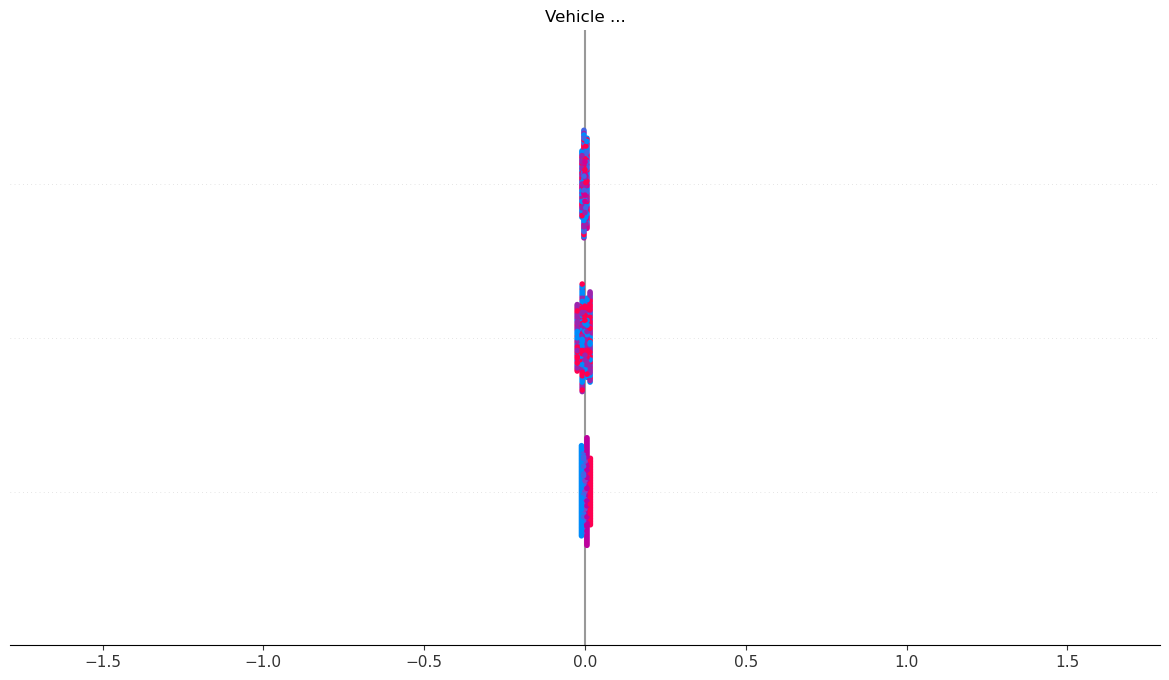

In [13]:
# SHAP Analysis
# SHAP analysis for Logistic Regression
explainer_lr = shap.LinearExplainer(log_reg, X_train, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values_lr, X_test, feature_names=X.columns)

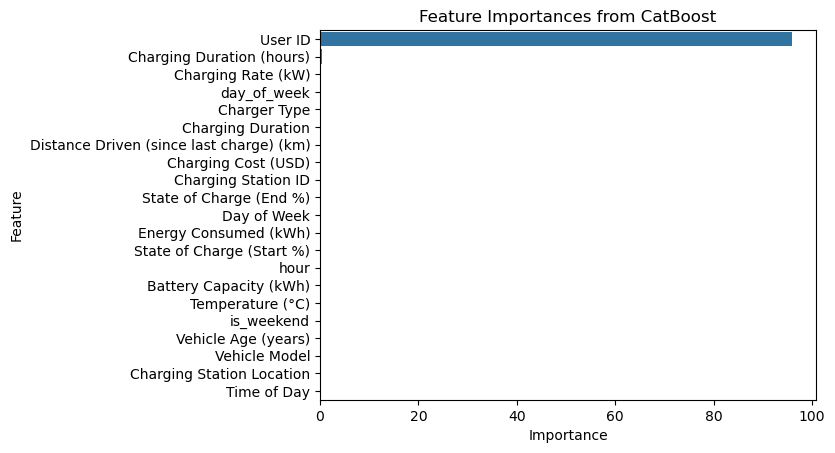

In [14]:
# Feature Importance Visualization
# Feature importance from CatBoost
importances = catboost_model.get_feature_importance()
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Plot
sns.barplot(data=feature_importances.sort_values(by='Importance', ascending=False), x='Importance', y='Feature')
plt.title('Feature Importances from CatBoost')
plt.show()

In [15]:
# Save Best Model
# Compare F1-scores
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
f1_cb = f1_score(y_test, y_pred_cb, average='macro')

print(f"Logistic Regression F1-score: {f1_lr:.4f}")
print(f"CatBoost F1-score: {f1_cb:.4f}")

# Select the best model
best_model = log_reg if f1_lr >= f1_cb else catboost_model

# Save the best model
import joblib
joblib.dump(best_model, 'best_ev_charging_model.pkl')

Logistic Regression F1-score: 0.9889
CatBoost F1-score: 1.0000


['best_ev_charging_model.pkl']